In [1]:
!pip install timm
import timm

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights 
from torchvision.models import resnet50, ResNet50_Weights 
from torch.utils.data import random_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import time
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pprint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9.90:
      Successfully uninstalled nvidia-curand-cu12-10.3.9.90
  Attempting

In [2]:
def extract_patient_ids(filename):
    patient_id = filename.split('_')[0].replace("person", "")
    return patient_id

def split_file_names(input_folder, val_split_perc):
    random.seed(42)
    
    # Pneumonia files contain patient id, so we group split them by patient to avoid data leakage
    pneumonia_patient_ids = set([extract_patient_ids(fn) for fn in os.listdir(os.path.join(input_folder, 'PNEUMONIA'))])
    pneumonia_val_patient_ids = random.sample(list(pneumonia_patient_ids), int(val_split_perc * len(pneumonia_patient_ids)))

    pneumonia_val_filenames = []
    pneumonia_train_filenames = []

    for filename in os.listdir(os.path.join(input_folder, 'PNEUMONIA')):
        patient_id = extract_patient_ids(filename)
        if patient_id in pneumonia_val_patient_ids:
            pneumonia_val_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))
        else:
            pneumonia_train_filenames.append(os.path.join(input_folder, 'PNEUMONIA', filename))

    # Normal (by file, no patient information in file names)
    normal_filenames  = [os.path.join(input_folder, 'NORMAL', fn) for fn in os.listdir(os.path.join(input_folder, 'NORMAL'))]
    normal_val_filenames = random.sample(normal_filenames, int(val_split_perc * len(normal_filenames)))
    normal_train_filenames = list(set(normal_filenames)-set(normal_val_filenames))

    train_filenames = pneumonia_train_filenames + normal_train_filenames
    val_filenames = pneumonia_val_filenames + normal_val_filenames

    return train_filenames, val_filenames

def create_weighted_sampler(h, dataset):
    targets = [label for _, label in dataset]
    class_counts = np.bincount(targets)
    class_weights = 1.0 / class_counts
    weights = [class_weights[label] for label in targets]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

def prepare_data(h):
    data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=(h["image_size"], h["image_size"])),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    data_transforms_train = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(30),  # Randomly rotate the image within a range of (-20, 20) degrees
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomResizedCrop(h["image_size"], scale=(0.7, 1.0)),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

    # Define the validation split percentage
    val_split = 0.2
    train_filenames, val_filenames = split_file_names("/kaggle/input/chest-xray-pneumonia/chest_xray/train/", val_split)

    # Load the datasets
    train_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train/", transform=data_transforms_train, is_valid_file=lambda x: x in train_filenames)
    val_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/train/", transform=data_transforms, is_valid_file=lambda x: x in val_filenames)    
    test_dataset = datasets.ImageFolder("/kaggle/input/chest-xray-pneumonia/chest_xray/test/", transform=data_transforms)

    # Create the data loaders for train, validation, and test sets
    if (h["balance"]):
        sampler = create_weighted_sampler(h, train_dataset)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=h["batch_size"], sampler=sampler, num_workers=4)    
    else:
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)    
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=h["batch_size"], shuffle=True, num_workers=4)

    
    return train_loader, val_loader, test_loader

def print_dataset_summary(loader, name):
    class_names = loader.dataset.classes
    class_counts = np.bincount([label for _, label in loader.dataset.samples])
    
    print(f"\n{name} Set Summary:")
    print(f"- Total samples: {len(loader.dataset)}")
    print("- Class distribution:")
    for i, count in enumerate(class_counts):
        print(f"  {class_names[i]}: {count} samples ({count/len(loader.dataset)*100:.1f}%)")

In [3]:
def create_model(h, device):
    if (h["model"]=="cnn"):
        model = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Dropout(h["dropout"]),
            nn.Linear(64 * (h["image_size"] // 8) * (h["image_size"] // 8), 512),
            nn.ReLU(),
            nn.Dropout(h["dropout"]),
            nn.Linear(512, 2)
        )
        model = model.to(device)
        return model

    if (h["model"]=="efficientnetv2"):
        model = timm.create_model('tf_efficientnetv2_s.in21k', pretrained=True)

        # Freeze
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze last layer (blocks[-1])
        for param in model.blocks[-1].parameters():
            param.requires_grad = True

        # Replace classifier
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(h["dropout"]),
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(h["dropout"]),
            nn.Linear(128, 2)
        )

        # Unfreeze FC layer
        for param in model.classifier.parameters():
            param.requires_grad = True

        model = model.to(device)
        return model
    
    if (h["model"]=="resnet50"):
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze
        for param in model.parameters():
            param.requires_grad = False

        # Unfreeze last layer (layer4)
        for param in model.layer4[-1].parameters():
            param.requires_grad = True

        # Replace FC layer
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(h["dropout"]),
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(h["dropout"]),
            nn.Linear(128, 2)
        )

        # Unfreeze FC layer
        for param in model.fc.parameters():
            param.requires_grad = True

        model = model.to(device)
        return model

In [4]:
def train_model(h, model, train_loader, val_loader, optimizer, criterion, scheduler, device):
    train_loss_history = []
    val_loss_history = []
    
    train_acc_history = [] 
    val_acc_history = []

    start_time = time.time()
    num_epochs = h["num_epochs"]

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch + 1}/{num_epochs}", leave=False, unit="mini-batch")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)      
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix(loss=loss.item())
        
        train_accuracy = correct / total
        train_acc_history.append(train_accuracy)

        val_loss, val_accuracy, _, _ = evaluate_model(h, model, val_loader, criterion, device)
        val_acc_history.append(val_accuracy)
        
        if (scheduler):
            scheduler.step(val_loss)
        
        # Store the loss history
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)     

        # Calculate elapsed time and remaining time
        elapsed_time = time.time() - start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        remaining_epochs = num_epochs - (epoch + 1)
        remaining_time = avg_time_per_epoch * remaining_epochs

        # Convert remaining time to minutes and seconds
        remaining_time_min, remaining_time_sec = divmod(remaining_time, 60)

        print(f"Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Remaining Time: {remaining_time_min:.0f}m {remaining_time_sec:.0f}s")
    # Save train history
    np.save('train_loss_history.npy', np.array(train_loss_history))
    np.save('val_loss_history.npy', np.array(val_loss_history))
    np.save('train_acc_history.npy', np.array(train_acc_history)) 
    np.save('val_acc_history.npy', np.array(val_acc_history))

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

def evaluate_model(h, model, data_loader, criterion, device):
    true_labels = []
    predicted_labels = []
    total_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)          

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = total_loss / len(data_loader)
    epoch_accuracy = float(correct / total)

    return epoch_loss, epoch_accuracy, true_labels, predicted_labels


def plot_metrics(h, 
                 train_loss_history, val_loss_history, 
                 train_acc_history, val_acc_history,
                 test_loss, test_accuracy, 
                 true_labels, predicted_labels):
    print(f"Accuracy on the test set: {test_accuracy:.2%}")

    # Calculate precision, recall, and F1 score using the accumulated true labels and predictions
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 score: {f1:.2f}")

    # Calculate the confusion matrix using the accumulated true labels and predictions
    cm = confusion_matrix(true_labels, predicted_labels)

    # Visualize the confusion matrix
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
    disp.plot()
    
    # Plot the learning curves
    plt.figure()
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss history')
    plt.legend()
    plt.show()  

    # Plot accuracy history
    plt.figure()
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()
    plt.show()

def create_scheduler(h, optimizer, lr):
    scheduler_name = h["scheduler"]
    if (scheduler_name==""):
        return None
    if (scheduler_name=="CosineAnnealingLR10"):
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=h["num_epochs"], eta_min=lr*0.1)
    if (scheduler_name=="ReduceLROnPlateau5"):
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    print ("Error. Unknown scheduler name '{scheduler_name}'")
    return None

In [5]:
def check_solution(h, device, verbose):
    train_loader, val_loader, test_loader = prepare_data(h)
    print_dataset_summary(train_loader, "TRAIN")
    print_dataset_summary(val_loader, "VALIDATION")
    print_dataset_summary(test_loader, "TEST")
    model = create_model(h, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=h["lr"], weight_decay=1e-4)
    scheduler = create_scheduler(h, optimizer, h["lr"])
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
        h, model, train_loader, val_loader, optimizer, criterion, scheduler, device)
    
    test_loss, test_accuracy, true_labels, predicted_labels = evaluate_model(
        h, model, test_loader, criterion, device)
    
    if verbose:
        plot_metrics(h,
                     train_loss_history, val_loss_history, 
                     train_acc_history, val_acc_history,
                     test_loss, test_accuracy, true_labels, predicted_labels)

    f1 = f1_score(true_labels, predicted_labels)
    
    save_path = "m_resnet50.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")
    
    return f1, test_accuracy

Device: cuda
Number of CPU cores: 4
GPU name: Tesla P100-PCIE-16GB
Hyperparameters:
{'balance': True,
 'batch_size': 32,
 'dropout': 0.5,
 'fc1_size': 512,
 'image_size': 224,
 'lr': 1e-05,
 'model': 'efficientnetv2',
 'num_epochs': 20,
 'scheduler': 'CosineAnnealingLR10'}
Running solution 1/1

TRAIN Set Summary:
- Total samples: 4137
- Class distribution:
  NORMAL: 1073 samples (25.9%)
  PNEUMONIA: 3064 samples (74.1%)

VALIDATION Set Summary:
- Total samples: 1079
- Class distribution:
  NORMAL: 268 samples (24.8%)
  PNEUMONIA: 811 samples (75.2%)

TEST Set Summary:
- Total samples: 624
- Class distribution:
  NORMAL: 234 samples (37.5%)
  PNEUMONIA: 390 samples (62.5%)


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [1/20]: Train Loss: 0.6716, Val Loss: 0.6842, Remaining Time: 68m 28s


Epoch [2/20]: Train Loss: 0.5338, Val Loss: 0.5945, Remaining Time: 64m 29s


Epoch [3/20]: Train Loss: 0.4496, Val Loss: 0.5288, Remaining Time: 60m 44s


Epoch [4/20]: Train Loss: 0.4014, Val Loss: 0.4574, Remaining Time: 57m 6s


Epoch [5/20]: Train Loss: 0.3687, Val Loss: 0.4339, Remaining Time: 53m 17s


Epoch [6/20]: Train Loss: 0.3449, Val Loss: 0.4578, Remaining Time: 49m 36s


Epoch [7/20]: Train Loss: 0.3251, Val Loss: 0.4013, Remaining Time: 46m 6s


Epoch [8/20]: Train Loss: 0.3148, Val Loss: 0.3669, Remaining Time: 42m 27s


Epoch [9/20]: Train Loss: 0.3111, Val Loss: 0.3385, Remaining Time: 38m 57s


Epoch [10/20]: Train Loss: 0.3033, Val Loss: 0.3446, Remaining Time: 35m 24s


Epoch [11/20]: Train Loss: 0.2923, Val Loss: 0.3496, Remaining Time: 31m 53s


Epoch [12/20]: Train Loss: 0.2964, Val Loss: 0.3543, Remaining Time: 28m 25s


Epoch [13/20]: Train Loss: 0.2888, Val Loss: 0.3422, Remaining Time: 24m 52s


Epoch [14/20]: Train Loss: 0.2855, Val Loss: 0.3083, Remaining Time: 21m 19s


Epoch [15/20]: Train Loss: 0.2814, Val Loss: 0.3074, Remaining Time: 17m 44s


Epoch [16/20]: Train Loss: 0.2878, Val Loss: 0.3365, Remaining Time: 14m 12s


Epoch [17/20]: Train Loss: 0.2734, Val Loss: 0.3067, Remaining Time: 10m 40s


Epoch [18/20]: Train Loss: 0.2716, Val Loss: 0.3110, Remaining Time: 7m 7s


Epoch [19/20]: Train Loss: 0.2728, Val Loss: 0.3190, Remaining Time: 3m 33s


Epoch [20/20]: Train Loss: 0.2673, Val Loss: 0.3046, Remaining Time: 0m 0s
Accuracy on the test set: 92.95%
Precision: 0.93, Recall: 0.96, F1 score: 0.94


<Figure size 640x480 with 0 Axes>

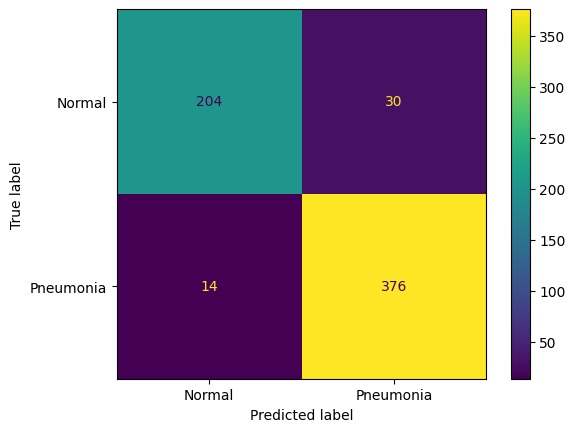

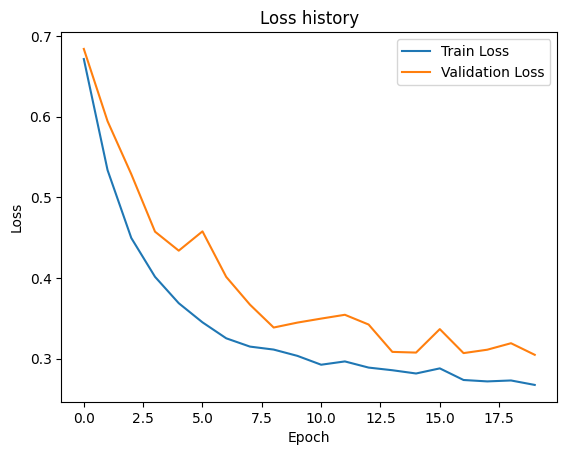

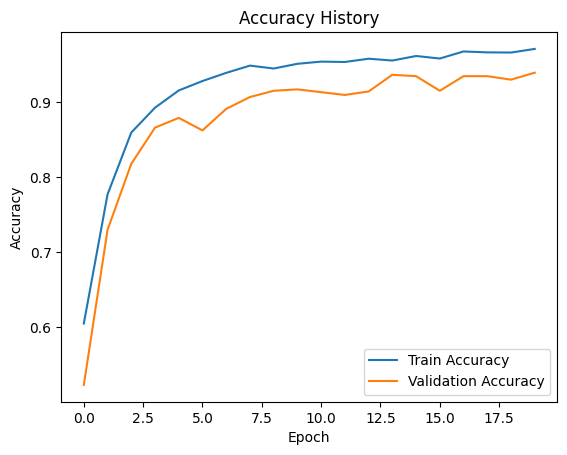

Model weights saved to m_resnet50.pth
F1 = 0.94, accuracy = 0.93


In [6]:
h = {
    "num_epochs": 20,
    "batch_size": 32,
    "image_size": 224,
    "fc1_size": 512,
    "lr": 1e-5,
    "model": "efficientnetv2",
    "scheduler": "CosineAnnealingLR10",
    "balance": True,
    "dropout" : 0.5
}

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Get number of CPU cores
num_cpu_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cpu_cores}")

# Get GPU name
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU name: {gpu_name}")
else:
    print("No GPU available")

# Print hyperparameters for records
print("Hyperparameters:")
pprint.pprint(h)

f1_array = np.array([])
accuracy_array = np.array([])
start_time = time.time()

# Run model
print("Running solution 1/1")
f1, accuracy = check_solution(h, device, verbose=True)
print(f"F1 = {f1:.2f}, accuracy = {accuracy:.2f}")

# Calculate time
elapsed_time = time.time() - start_time
elapsed_min, elapsed_sec = divmod(elapsed_time, 60)

In [7]:
# def load_model(h, device, path):
#     model = create_model(h, device)
#     # Load weights
#     model.load_state_dict(torch.load(path))
#     model.eval() 
#     return model

# loaded_model = load_model(h, device, '/content/weigth_efficientnetv2.pth')